In this notebook, I am going to implement this notebok: 

https://github.com/Hadisalman/nips_pgm/blob/master/notebooks/Set%20Up%20a%20experiment%20for%20skewed%20posterior.ipynb 

using TensorFlow. Then, I am going use your code for inference of the posterior. This is to help you start this experiment.


In [1]:
import sys
sys.path.append('/home/hadis/Hadi/nips_pgm/code')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from distributions import density_1
from flows import ResnetFlow, PlanarFlow
from losses import elbo_loss, vanilla_vae_loss, elbo_loss_resnet, cross_entropy_loss, density_regeneration_loss
from mag.experiment import Experiment
# from tb_logger import Logger
from utils import plot_density, scatter_points, detJacHeatmap, deformationGrid, displacementField

import numpy as np
import tensorflow as tf
from IPython import embed

In [3]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Factorial does not have a function TF but you can simply implement it using gamma function:

In [4]:
sess.run(tf.exp(tf.lgamma(5.0)))

24.0

Now, let's implement $n \choose r$:

In [5]:
from scipy.special import comb

n = 8.0
k = 4.0
comb(n, k, exact=False)

70.0

In [6]:
def tfComb(n,k):
    num = tf.lgamma(n+1)
    denum = tf.lgamma(k+1) + tf.lgamma(n-k+1)
    
    return tf.exp(num-denum)

sess.run(tfComb(n,k))

69.99999

We need the log of `rfComb` but that is easy. Let me test `lbeta` function:

In [7]:
import scipy.special as sp

In [8]:
a = 1.0
b = 2.0

sp.betaln(a,b)

-0.6931471805599453

In [9]:
sess.run(tf.lbeta([a,b]))

-0.6931472

In [10]:
print ( sess.run(tf.lbeta( tf.convert_to_tensor(  [a,b])) )  )

-0.6931472


OK, that works. Let's implement this function:


The likelihood of this model is beta-binomial looks like this:
$$
f(x \mid \alpha, \beta, n) =
       \binom{n}{x}
       \frac{B(x + \alpha, n - x + \beta)}{B(\alpha, \beta)}
$$



In [11]:
def logBetaBinomial(x,n,alpha,beta):
    def logComb(n,k):
        num = tf.lgamma(n+1)
        denum = tf.lgamma(k+1) + tf.lgamma(n-k+1)
        return tf.cast(num-denum, tf.float32)
    
    def betaln(x, y):
        return tf.cast(tf.lgamma(x) + tf.lgamma(y) - tf.lgamma(x + y), tf.float32)
        
#     val = bound(logComb(n,x) + betaln(x + alpha, n - x + beta) - betaln(alpha, beta),
#                     alpha > 0, beta > 0)
    val = logComb(n,x) + betaln(x + alpha, n - x + beta) - betaln(alpha, beta)
    return tf.cast(val,tf.float32)
    

Finally, the model is as follows:
$$
p(m,k) \propto \frac{1}{m(1-m)(1+K)^2} \\
P(x_j | m,K) = {n_j \choose x_j} \frac{B(Km+x_j , K(1-m) + n_j - x_j )}{ B(Km,K(1-m)) }
$$

basically, in our likelihood $\alpha = Km$ and $\beta = K(1-m)$. Similar to the paper, we define two variables to avoid the constrins:

$$
y_1 = \text{logit}(m),\quad y_2 = \log(K) 
$$

In [12]:
def logModel(X,N,z):
    """
    X : array of x data
    N : array of N data
    z : it is vector of y_1 and y_2
    """
    y1, y2 = tf.split(z, [1,1], axis=1) 
    m = tf.sigmoid(y1)
    K = tf.exp(y2)
    logPrior = tf.cast(2.0*tf.log( 1 + tf.exp(-y1) ) +y1 - 2.0*tf.log(1+ tf.exp(y2)), tf.float32) 
    logp = 0
    for x,n in zip(X,N):
        logp = logp + logBetaBinomial(x, n , K*m, K*(1-m))
    
    logp = tf.reshape(logp,(-1,1)) + logPrior
    return logp



In [13]:
import pandas as pd

data = pd.read_csv('cancermortality.csv')
x_data = np.array(data.y, dtype=np.float)
n_data = np.array(data.n, dtype=np.float)

Let's see if I can get it working with your engine. If I fail, you can try from there

In [14]:
experiment = Experiment({ "batch_size": 40,
						"iterations": 10000,
						"learning_rate": 0.001,
						"flow_length": 2,
						"flow": "resnet",
						"exp_name": "temp"})

config = experiment.config
experiment.register_directory("distributions")
experiment.register_directory("postTrainingAnalysis")
experiment.register_directory("samples")
experiment.register_directory("tensorboard")

In [15]:
# Other parameters
z_dim = 2
log_interval = 300

# ResnetFlow paramteres
if config.flow == 'resnet':
	num_flows= config.flow_length
	num_cells_per_flow = 8
	dt = tf.constant(1.0/(num_cells_per_flow*num_flows), name='dt')
	approximation = 2 # 1 , 2 , 3 or 4 - None for exact calculation of the determinant of jacobian

density_2 = lambda z: tf.exp(logModel(x_data,n_data,z))

plot_density(density_2, directory=experiment.distributions, X_LIMS=(-8,-5),Y_LIMS=(4,8))
# plot_density(density_2, directory=experiment.distributions, X_LIMS=(-2,2),Y_LIMS=(-2,2))
# plot_density(density_1, directory=experiment.distributions)
Z = tf.placeholder(tf.float32, shape =[None, 2], name='random_sample')

with tf.variable_scope('Flow'):
	if config.flow == 'resnet':
		flow = ResnetFlow(num_flows, num_cells_per_flow, z_dim, dt, approximation=approximation)
		z_k, sum_log_detj = flow.flow(Z)
	if config.flow == 'planar':
		flow = PlanarFlow(z_dim)
		z_k, sum_log_detj = flow.flow(Z, num_flows=config.flow_length)

loss_op, density = density_regeneration_loss(density_2, z_k, sum_log_detj)
tf.summary.scalar("loss", loss_op)

global_step = tf.Variable(0, trainable=False, name='global_step')

optimizer = tf.train.GradientDescentOptimizer(learning_rate=config.learning_rate)
gvs = optimizer.compute_gradients(loss_op)
# capped_gvs = [(tf.where(tf.is_nan(grad), tf.zeros_like(grad), grad), var) for grad, var in gvs]
capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
train_op = optimizer.apply_gradients(capped_gvs)

# train_op = tf.train.AdamOptimizer(config.learning_rate).minimize(loss_op, global_step=global_step)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(experiment.tensorboard)
summaries = tf.summary.merge_all()

for iteration in range(1, config.iterations + 1):
    z_samples = np.random.normal(0.0, 1.0, [config.batch_size,2])
    _, loss, _,sldg, summ, den, grads = sess.run([train_op, loss_op, z_k, sum_log_detj, summaries, density, capped_gvs], feed_dict={Z: z_samples})
    step = tf.train.global_step(sess, tf.train.get_global_step())
    # print('sum_log_detj',str(sldg))
    if iteration % log_interval == 0:
        writer.add_summary(summ, global_step=step)
        print("Loss on iteration {}: {}".format(iteration , loss))
        z_samples = np.random.normal(0.0, 1.0, [1000,z_dim])
        output = sess.run(z_k, feed_dict={Z: z_samples})
        scatter_points(
            output,
            directory=experiment.samples,
            iteration=iteration,
            flow_length=config.flow_length,
            X_LIMS=(-8,-5), 
            Y_LIMS=(4,8)
            )

Loss on iteration 300: 64.3335952758789
Loss on iteration 600: 58.47216033935547
Loss on iteration 900: 55.91584014892578
Loss on iteration 1200: 53.67760467529297
Loss on iteration 1500: 49.967918395996094
Loss on iteration 1800: 49.394287109375
Loss on iteration 2100: 48.764732360839844
Loss on iteration 2400: 46.792274475097656
Loss on iteration 2700: 46.26799011230469
Loss on iteration 3000: 45.484764099121094
Loss on iteration 3300: 43.98137664794922
Loss on iteration 3600: 44.65618133544922
Loss on iteration 3900: 42.45880126953125
Loss on iteration 4200: 41.16578674316406
Loss on iteration 4500: 41.16004180908203
Loss on iteration 4800: 40.021244049072266
Loss on iteration 5100: 39.74425506591797
Loss on iteration 5400: 39.87838363647461
Loss on iteration 5700: 39.38446044921875
Loss on iteration 6000: 39.285987854003906
Loss on iteration 6300: 39.29726791381836
Loss on iteration 6600: 39.141571044921875
Loss on iteration 6900: 39.415931701660156
Loss on iteration 7200: 39.40293

In [16]:
import numpy as np
import pandas as pd
import seaborn as sb
from scipy import stats
import pymc3 as pm

def plotTheResults(trace):
    # Obtain data from file.
    m1, m2 = trace[::10,0], trace[::10,1]
    xmin, xmax = -7.5, -5.75
    ymin, ymax = 4.8, 9

    # Perform a kernel density estimate (KDE) on the data
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([m1, m2])
    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    # Plot the results:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    # Set limits
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    
    # Draw contour lines
    cset = plt.contour(xx,yy,f)
    
    # plot the trace
    plt.figure()
    pm.plots.densityplot(trace, varnames=['y_1','y_2']);
    
    # more plot
    pm.traceplot(trace, varnames=['y_1','y_2']);
    
    # new plot
    plt.figure()
    dftrace = pm.trace_to_dataframe(trace)
    sb.jointplot(dftrace.iloc[::10, 0], dftrace.iloc[::10, 1], kind='kde');

AttributeError: 'numpy.ndarray' object has no attribute 'varnames'

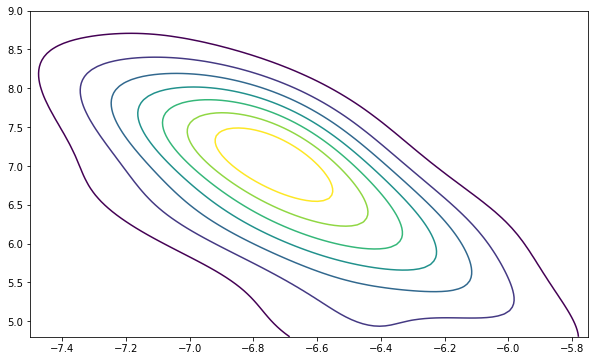

<Figure size 432x288 with 0 Axes>

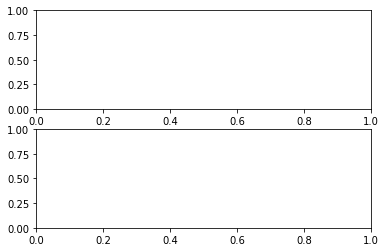

In [17]:
z_samples = np.random.normal(0.0, 1.0, [1000,z_dim])
trace = sess.run(z_k, feed_dict={Z: z_samples})
plotTheResults(trace)